Initial model was quite good, but after doing some research regarding active learning I figured, that it can be improved.

In [2]:
import torch
from torch.utils.data import DataLoader

from src import data, model, train, visualization

### Here I prepare the data

In [7]:
train_data_path = './data/train_32x32.mat'
test_data_path = './data/test_32x32.mat'

x_train, y_train = data.prepare_data(train_data_path)
x_test, y_test = data.prepare_data(test_data_path)

split = int(0.8 * len(x_train))

train_dataset = data.SVHNDataset(x_train[:split], y_train[:split])
val_dataset = data.SVHNDataset(x_train[split:], y_train[split:])
test_dataset = data.SVHNDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

loss_fn = torch.nn.CrossEntropyLoss()

len(train_dataset), len(val_dataset), len(test_dataset)

(37272, 9318, 15950)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Optimiser

According to several papers best optimiser for active learning is SGD (since it generalises better) with learning rate of 0.1.

Link to the article with those recommendations: [Randomness Is the Root of All Evil:
More Reliable Evaluation of Deep Active Learning](https://openaccess.thecvf.com/content/WACV2023/papers/Ji_Randomness_Is_the_Root_of_All_Evil_More_Reliable_Evaluation_WACV_2023_paper.pdf)

In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
cnn_model = model.DropoutCNN(0.2).to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.1, momentum=0.9)

checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 10, loss_fn, optimizer, disable_logs=False)

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, avg training loss is 1.5548, avg validation loss is 0.7361, acc on train set is 46.91% and acc on validation set is 76.89%
After epoch 1, avg training loss is 0.9830, avg validation loss is 0.7844, acc on train set is 70.47% and acc on validation set is 77.23%
After epoch 2, avg training loss is 1.0005, avg validation loss is 0.8590, acc on train set is 71.35% and acc on validation set is 73.78%
After epoch 3, avg training loss is 1.0705, avg validation loss is 0.9103, acc on train set is 70.24% and acc on validation set is 73.70%
After epoch 4, avg training loss is 1.1468, avg validation loss is 0.7924, acc on train set is 68.64% and acc on validation set is 80.11%
After epoch 5, avg training loss is 1.3476, avg validation loss is 1.1911, acc on train set is 63.06% and acc on validation set is 65.58%
After epoch 6, avg training loss is 1.6134, avg validation loss is 1.4680, acc on train set is 56.04% and acc on validation set is 65.57%
After epoch 7, avg training loss i

That started OK, but model has quickly lost its course.

It is possible, that learning rate of 0.1 would still work better during active learning, but I'd rather stick to more classical value, that shouldn't change much.

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
cnn_model = model.DropoutCNN(0.2).to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 100, loss_fn, optimizer, disable_logs=True)

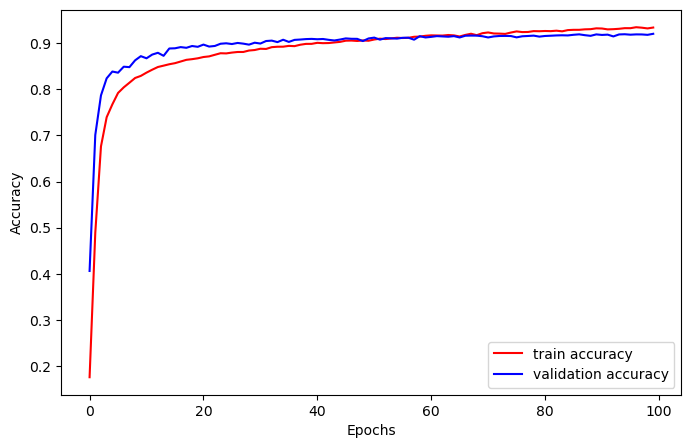

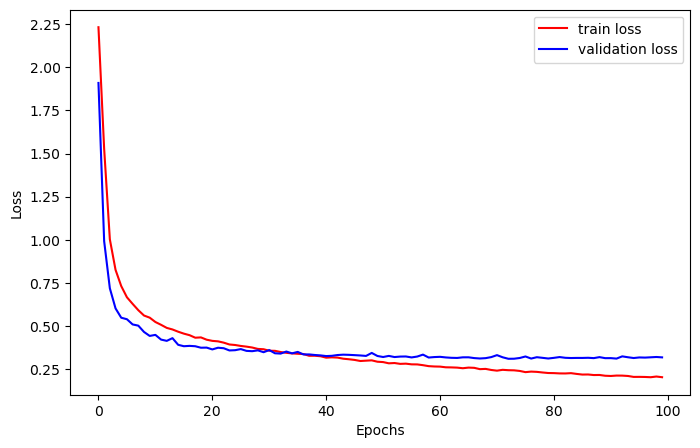

In [12]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])

In [14]:
trained_model = model.DropoutCNN(0.2).to(device)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 91.0157%, test loss: 0.3440


The generalizations is a bit better than with Adam, so I would use SGD for future test.

# Stable output layer

According to [Improving monte carlo dropout uncertainty estimation with stable output layers](https://www.sciencedirect.com/science/article/pii/S0925231225025998) paper, not adding dropout before the final layer can result in better uncertainty estimation.

Unfortunately, I cannot test this myself (since I don't have reference uncertainty and it is a bit beyond the scope of this project) I can it lest check, that elimnating one dropout layer doesn't hurt our models performance too much.

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
cnn_model = model.SOLDropoutCNN(0.2).to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 100, loss_fn, optimizer, disable_logs=True)

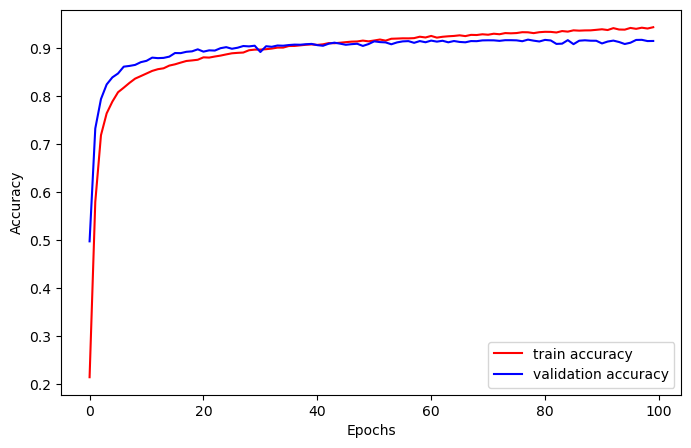

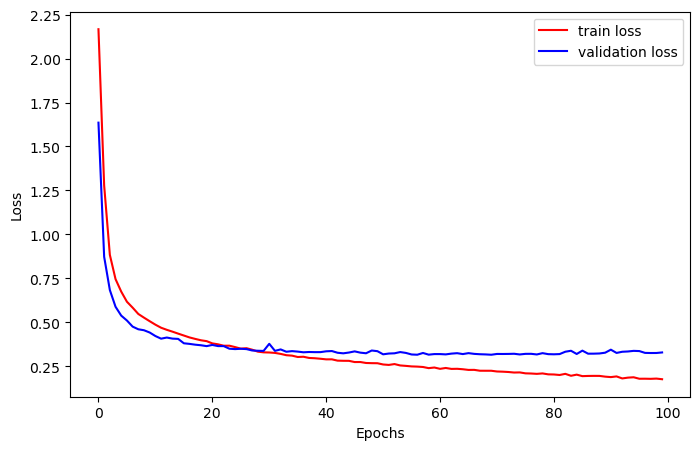

In [16]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])

In [17]:
trained_model = model.SOLDropoutCNN(0.2).to(device)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 91.1160%, test loss: 0.3265


This result is even a bit better! Maybe because this model gives better performance, or maybe because it converges faster and I need more than 100 epochs to train SGD.

Anyway, seems reasonable to keep this technique.

# Concrete dropout

Dropout probability hyperparameter has a great effect on Monte Carlo Dropout performance in uncertainty estimation. To get better performance it is needed to calibrate it with hyperparameter tuning (ideally I would need to tune this probability for every layer).

Thankfully, I am lazy, so instead I would implement the technique called [Concrete Dropout](https://arxiv.org/pdf/1705.07832) which allows me to adjust the probability of dropout for every layer during training.

I am also implementing improvements to Concrete Dropout calculations from [Simplified Concrete Dropout - Improving the Generation of Attribution Masks for Fine-grained Classification](https://link.springer.com/article/10.1007/s11263-025-02453-z) for better numerical stability.

I will keep values of weight regularization and dropout regularization which gives better performance (yes, I did some fine-tuning).

In [52]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
cnn_model = model.ConcreteDropoutCNN(1e-5, 1e-3).to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 100, loss_fn, optimizer, disable_logs=True)

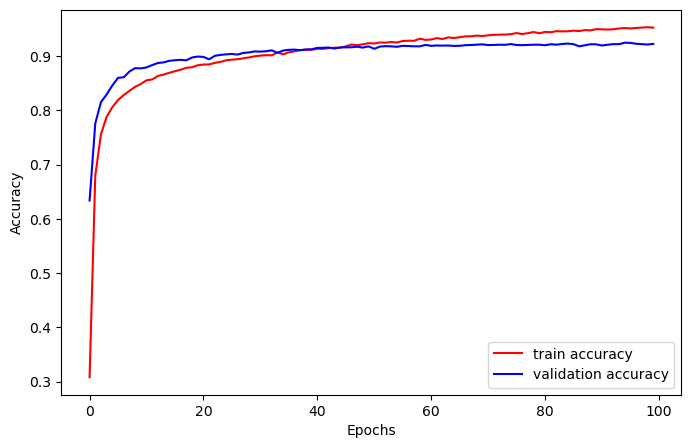

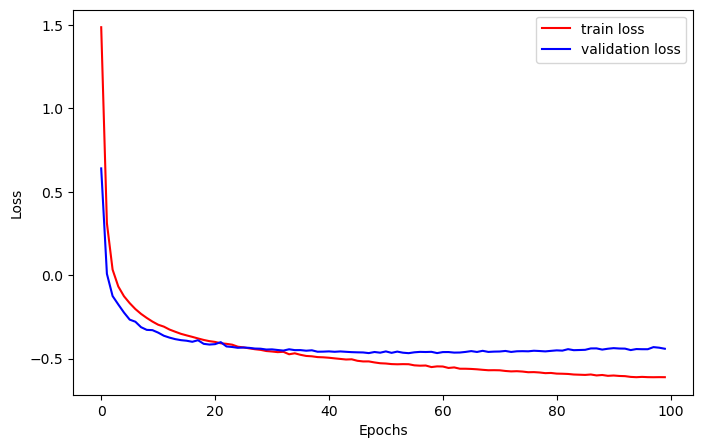

In [53]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])

In [57]:
trained_model = model.ConcreteDropoutCNN(1e-5, 1e-3).to(device)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 91.4420%, test loss: 0.3302


Seems like Concrete Dropout helped to improve performance.

Let's see what is happening with dropout layers.

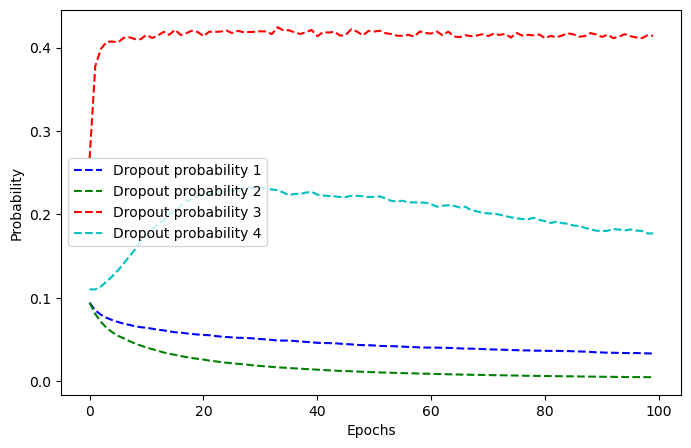

In [58]:
visualization.plot_dropout_change(history['probs'])

Dropout probability is clearly changing during training. Starting from initial 0.1 and to some balanced level.